# Quick start tutorial for CytoVI
In this tutorial, we go through the steps of training CytoVI, a deep generative model that leverages antibody-based single-cell profiles to learn a biologically meaningful latent representation of each cell. CytoVI is designed for protein expression measurements (from flow cytometry, mass cytometry or CITE-seq data) and captures both technical and biological variation, enabling the generation of denoised marker intensities and interpretable low-dimensional embeddings.

In this tutorial, we go through the steps of training a CytoVI model using full spectrum cytometry data of peripheral blood mononuclear cells (PBMCs). We will analyze two repeated measurements of cryopreserved PBMCs from the same biological donor that were thawed and analyzed on two consecutive days (and thereby only differ in technical variation). We will demonstrate how CytoVI yields a joint cell state representation across these two measurements and effectively mitigates technical variation. We will then utilized this shared cell representation to annotate the immune subsets present in the PBMCs and quantify their abundance.

Plan for this tutorial:

1. Loading the data
2. Preprocessing the data and quality control
3. Training a CytoVI model
4. Visualizing and clustering the CytoVI latent space
4. Quantifying the abundance of immune cells present in the PBMCs

In [3]:
# Install from GitHub for now
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/projects/amit/floriani/mambaforge/envs/cytovi_integration_env/lib/python3.11/site-packages/scvi_colab/_core.py:42: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import ContextualVersionConflict
/home/projects/amit/floriani/mambaforge/envs/cytovi_integration_env/lib/python3.11/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import random
import tempfile

import numpy as np  # type: ignore
import scanpy as sc  # type: ignore
import scvi  # type: ignore
import torch  # type: ignore
from rich import print  # type: ignore

sc.set_figure_params(figsize=(4, 4))
save_dir = tempfile.TemporaryDirectory()

scvi.settings.seed = 0
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.2

# Loading the data

For this tutorial we will use full spectrum cytometry data of a single antibody-panel targeting 35 protein parameters and additional morphological features for FSC and SSC from the SARS-CoV-2 vaccine study from Nuñez, Schmid & Power et al. 2023 (Nature Immunology, https://doi.org/10.1038/s41590-023-01499-w). We will download a subset of the data comprising one donor that was measured in two different batches and thus served as a internal batch normalization control of the original study. Importantly, these data have already been corrected for fluorescent spillover and live single cells were exported.

We will download the fcs files and store the cytometry data as an AnnData object, similarly as common practice in scRNAseq and spatial transcriptomics analyses. If you are unfamilliar with AnnData, you can get a quick start here: https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html.

When reading the fcs files we will omit variables that are not informative for downstream processing `remove_markers=['Time', 'LD', '-']`. By default we store the raw protein expression in `adata.X` and `adata.layers['raw']`.

In [22]:
# replace by figshare data download
data_dir = '/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/data/raw/Spectral flow/Nunez/For Chiquito/Raw_100000'
adata_batch1 = scvi.external.cytovi.read_fcs(f"{data_dir}/export_Tube_086_DownsampleDP.Pop_2.fcs", remove_markers=['Time', 'LD', '-'])
adata_batch2 = scvi.external.cytovi.read_fcs(f"{data_dir}/export_Tube_327_DownsampleDP.Pop_2.fcs", remove_markers=['Time', 'LD', '-'])
adata_batch1

/home/projects/amit/floriani/github_repos/scvi-tools-cytovi/src/scvi/external/cytovi/_read_write.py:95: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["filename"] = fcs_file
/home/projects/amit/floriani/github_repos/scvi-tools-cytovi/src/scvi/external/cytovi/_read_write.py:95: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["filename"] = fcs_file


AnnData object with n_obs × n_vars = 100000 × 41
    obs: 'filename', 'sample_id'
    layers: 'raw'

Before training CytoVI, we need to transform and normalize the cytometry data to make it more suitable for modeling.

Full spectrum cytometry produces fluorescence intensities that span several orders of magnitude. Because antibody-based single-cell measurements are relative by nature, preprocessing of the data is commonly performed before visualization or modeling. Cytometry data are typically transformed using functions like the hyperbolic arcsin, logicle, or biexponential to compress dynamic range and stabilize variance. This is usually followed by feature-wise scaling to ensure marker expression values are on comparable scales across all channels (more information can be found at Liechti et al. 2021, Nature Immunology, https://doi.org/10.1038/s41590-021-01006-z).

While CytoVI is capable of handling cytometry data preprocessed with any of these transformations, we here follow a simple two-step preprocessing strategy commonly used for cytometry:
1. This transformation is widely used in flow cytometry to stabilize variance and improve comparability across markers. It behaves linearly at low intensities and logarithmically at high intensities.
2.	Feature-wise min-max scaling
After transformation, we rescale each marker (feature) individually to the [0, 1] range to account for differences in brightness across different fluorophores or antibody affinities.


The choice of the arcsinh cofactor can influence the data. However, we have observed that CytoVI is relatively robust to the choice of the arcsinh cofactor and recommend a `global_scaling_factor` for all markers as following:
- 2000 for full spectrum cytometry (recommended here)
- 100 for conventional PMT-based flow cytometry
- 5 for mass cytometry (CyTOF and CITE-seq)

Users can specify feature-specific arcsinh cofactors by providing a `scaling_dict` to `scvi.external.cytovi.arcsinh()`. By default `scvi.external.cytovi.arcsinh()` will take the `adata.layers['raw']` as input and write the arcsinh transformed expression into `adata.layers['transformed']`, while `scvi.external.cytovi.scale` will save the scaled expression in `adata.layers['scaled']`.

In [23]:
scvi.external.cytovi.arcsinh(adata_batch1, global_scaling_factor=2000)
scvi.external.cytovi.scale(adata_batch1)

scvi.external.cytovi.arcsinh(adata_batch2, global_scaling_factor=2000)
scvi.external.cytovi.scale(adata_batch2)

/tmp/ipykernel_1265/278245467.py:1: UserWarning: Detected scatter features, which are omitted for transformation. 
Scatter features: FSC-A, FSC-H, SSC-A, SSC-B-A, SSC-B-H, SSC-H
  scvi.external.cytovi.arcsinh(adata_batch1, global_scaling_factor=2000)
/tmp/ipykernel_1265/278245467.py:4: UserWarning: Detected scatter features, which are omitted for transformation. 
Scatter features: FSC-A, FSC-H, SSC-A, SSC-B-A, SSC-B-H, SSC-H
  scvi.external.cytovi.arcsinh(adata_batch2, global_scaling_factor=2000)


After processing each batch separately, we will combine the two batches using `scvi.external.cytovi.merge_batches()`. This will automatically register a `batch_key` in `adata.obs`. In case of differences in antibody panels between the batches, this function will automatically register a `nan_layer` that will handle the modeling of missing markers under the hood.

In [24]:
adata = scvi.external.cytovi.merge_batches([adata_batch1, adata_batch2])
adata

/home/projects/amit/floriani/mambaforge/envs/cytovi_integration_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 200000 × 41
    obs: 'filename', 'sample_id', 'batch'
    layers: 'raw', 'transformed', 'scaled'

For the ease of handling the data, we will subsample the combined data to 10 000 cells per batch.

In [25]:
adata = scvi.external.cytovi.subsample(adata, n_obs = 20000, groupby = 'batch')
adata

/home/projects/amit/floriani/github_repos/scvi-tools-cytovi/src/scvi/external/cytovi/_preprocessing.py:356: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  index = adata.obs.groupby(groupby, as_index=False).apply(


AnnData object with n_obs × n_vars = 20000 × 41
    obs: 'filename', 'sample_id', 'batch'
    layers: 'raw', 'transformed', 'scaled'

We can then inspect the scaled protein expression for all the markers in both batches using histograms or biaxial plots.

/home/projects/amit/floriani/github_repos/scvi-tools-cytovi/src/scvi/external/cytovi/_preprocessing.py:356: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  index = adata.obs.groupby(groupby, as_index=False).apply(


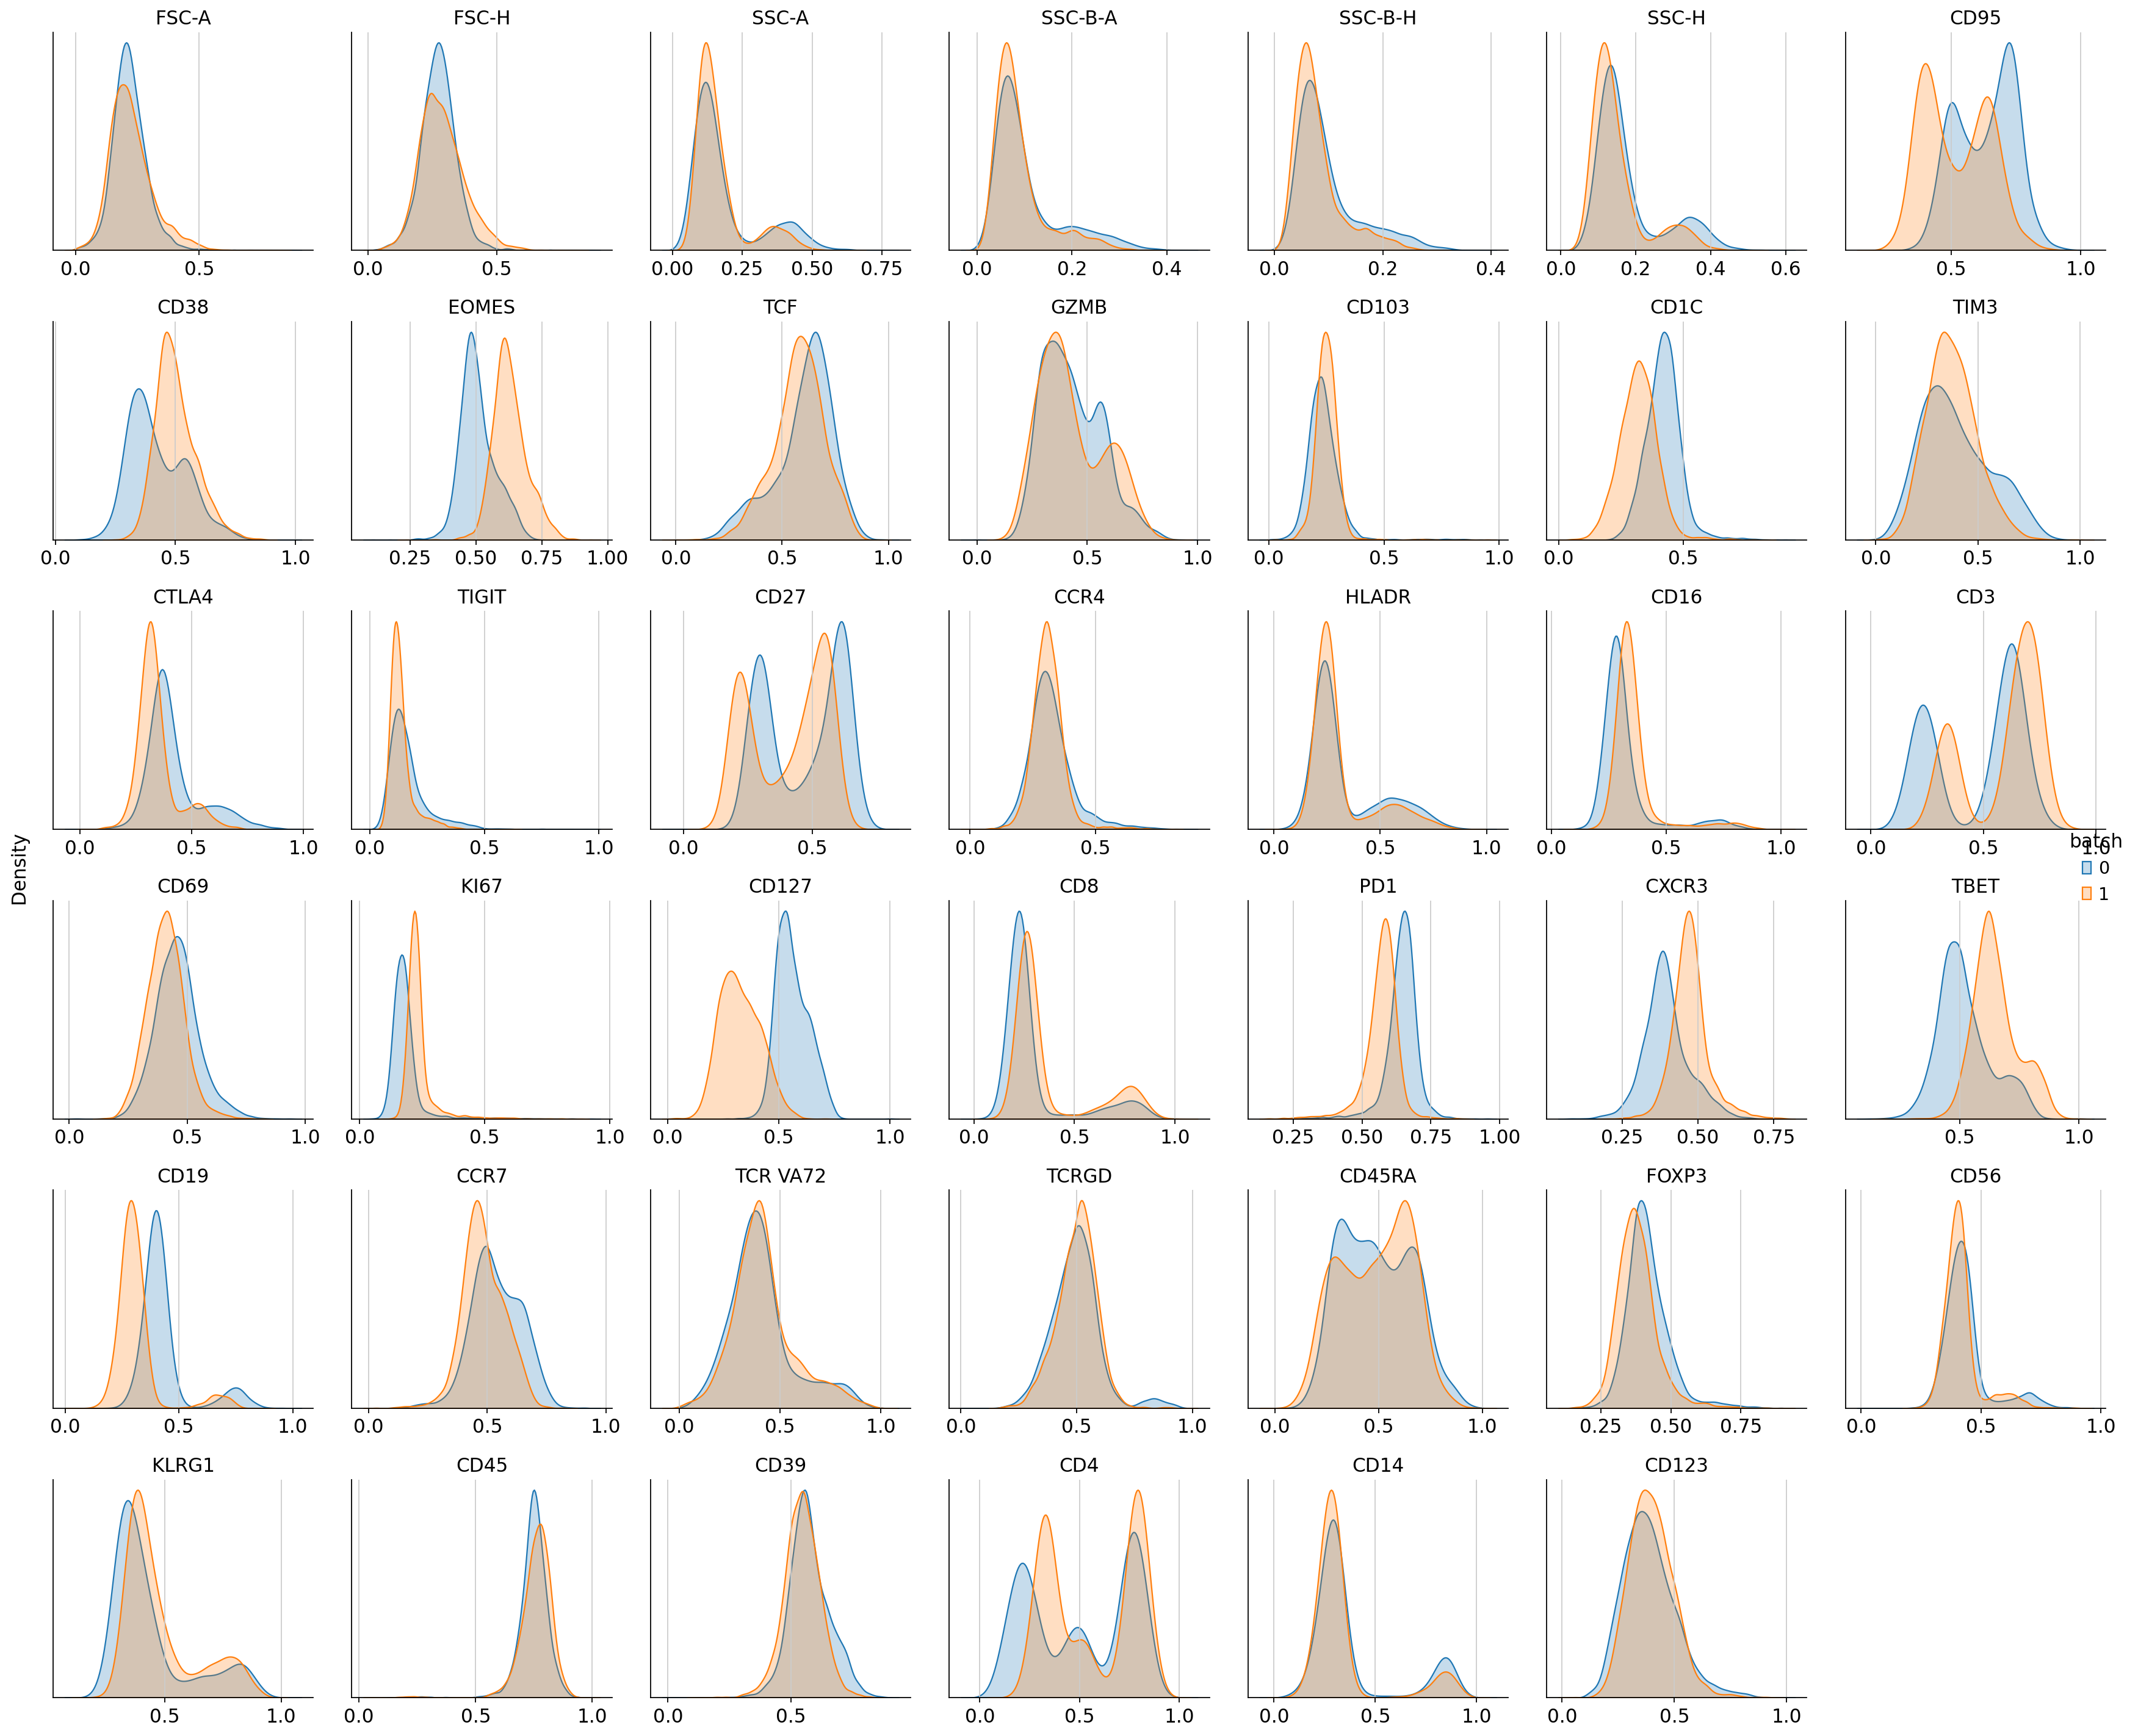

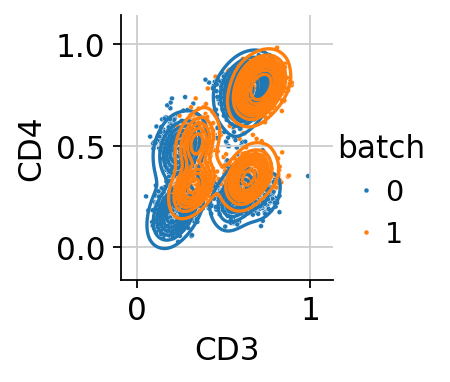

In [26]:
scvi.external.cytovi.histogram(adata, marker = 'all', groupby='batch', layer_key='scaled')
scvi.external.cytovi.biaxial(adata, marker_x = 'CD3', marker_y = 'CD4', color='batch', layer_key='scaled')

Inspection of these diagnostic plots indicates already the presence of technical variation between both batches. We will assess how this affects an embedding of our data by computing a UMAP from the data without controlling for technical variation. Throughout this tutorial we will use the GPU-accellerated scanpy implementations to compute a nearest neighbor graph, UMAP and leiden clustering, which will lead to performance improvements when working with large datasets.

Next, we will train a CytoVI model that explicitly controls for the technical variation between batches.

In [35]:
def get_gene_percentiles_list(adata, gene_list, p, layer=None):
    """
    Calculate the p-percentile of gene expression for a list of genes in an AnnData object.

    Parameters
    ----------
        adata (AnnData): The AnnData object containing expression data.
        gene_list (list): List of gene names for which to compute percentiles.
        p (float): Percentile to compute (between 0 and 100).
        layer (str or None): The layer from which to retrieve expression data.
                             If None, uses `adata.X`.

    Returns
    -------
        list: A list of p-percentile values for the genes, in the same order as gene_list.
              If a gene is not found, its value will be `None`.
    """
    percentiles = []

    for gene in gene_list:
        if gene in adata.var_names:
            if layer:
                data = adata[:, gene].layers[layer].flatten()
            else:
                data = adata[:, gene].X.flatten()

            # Compute the percentile
            percentiles.append(np.percentile(data, p))
        else:
            percentiles.append(None)  # Handle genes not in adata.var_names

    return percentiles

We display _ESM1_, _KDR_, _SNAI1_, critical genes for angiogenesis in invasive cancer. We aslo display _FOXA1_, that is both upregulated in $\textit{G1}$ and $\textit{N1}$, to show how our procedure can filter such genes. 

In [36]:
gene_list_invasive = ["ESM1", "KDR", "SNAI1", "FOXA1"]
percentiles_invasive = get_gene_percentiles_list(
    adata, gene_list_invasive, 99.9, layer="min_max_scaled"
)

We first plot these genes in endothelial cells:

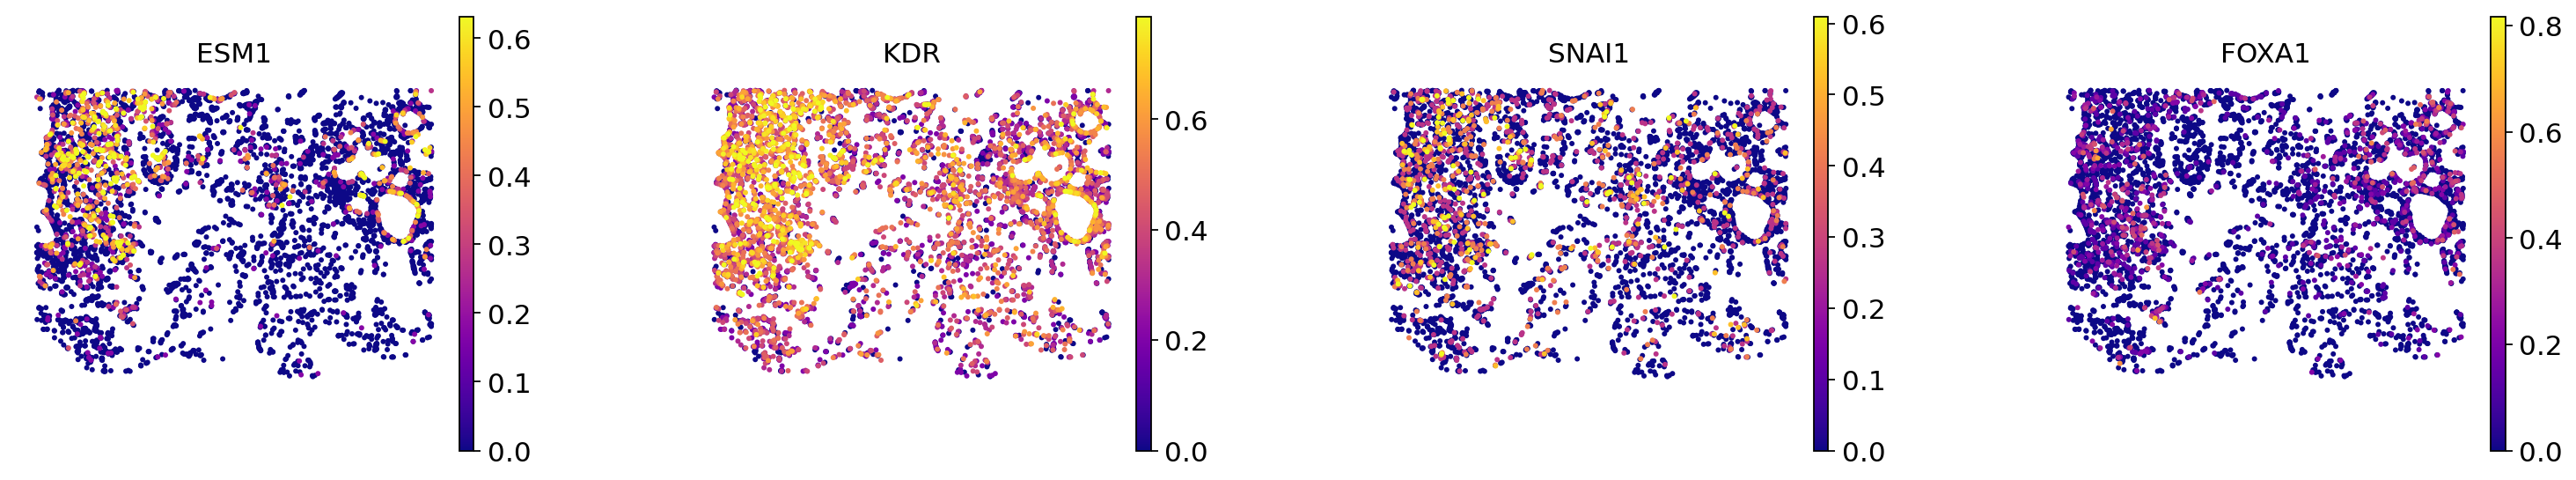

In [37]:
plot_endo = True

sc.pl.spatial(
    adata=adata_endothelial if plot_endo else adata_not_endo,
    spot_size=100 if plot_endo else 40,
    color=gene_list_invasive,
    frameon=False,
    use_raw=False,
    wspace=0.4,
    vmax=percentiles_invasive,
    layer="min_max_scaled",
    cmap="plasma",
)

Then in all cells but endothelial:

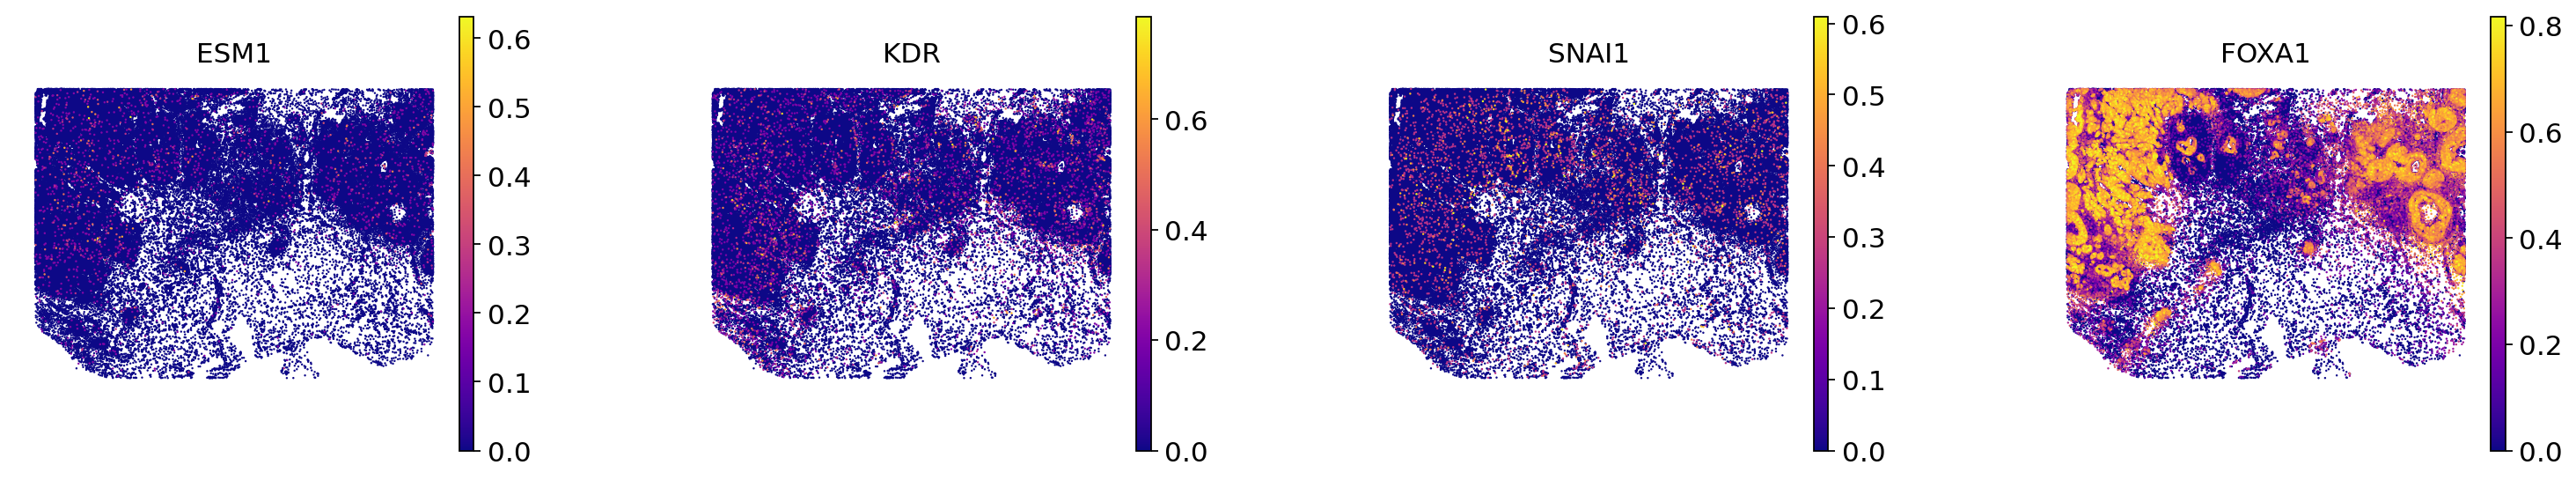

In [38]:
plot_endo = False

sc.pl.spatial(
    adata=adata_endothelial if plot_endo else adata_not_endo,
    spot_size=100 if plot_endo else 40,
    color=gene_list_invasive,
    frameon=False,
    use_raw=False,
    wspace=0.4,
    vmax=percentiles_invasive,
    layer="min_max_scaled",
    cmap="plasma",
)